<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки** <br><br>
DateCrawled — дата скачивания анкеты из базы <br>
VehicleType — тип автомобильного кузова <br>
RegistrationYear — год регистрации автомобиля <br>
Gearbox — тип коробки передач <br>
Power — мощность (л. с.) <br>
Model — модель автомобиля <br>
Kilometer — пробег (км) <br>
RegistrationMonth — месяц регистрации автомобиля <br>
FuelType — тип топлива <br>
Brand — марка автомобиля <br>
NotRepaired — была машина в ремонте или нет <br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>
<br>
Целевой признак
Price — цена (евро)

## Подготовка данных

Загружаем необходимые бибилиотеки

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

import lightgbm 
from catboost import CatBoostRegressor

import time

from IPython.display import display

Импорт и изучение данных

In [39]:
try:
    data = pd.read_csv('autos.csv') 
except:
    data = pd.read_csv('/datasets/autos.csv')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [41]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [42]:
print('Количество пропусков', data.isna().mean())

Количество пропусков DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


Проверим на дубликаты

In [43]:
data[data.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим дубликаты

In [44]:
data = data.drop_duplicates()

Удалим признаки, которые не понадобятся в исследовании:

In [45]:
data = (data.drop(
    columns=['DateCrawled', 'Model','RegistrationMonth', 'DateCreated','NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Kilometer         354365 non-null  int64 
 6   FuelType          321470 non-null  object
 7   Brand             354365 non-null  object
 8   Repaired          283211 non-null  object
dtypes: int64(4), object(5)
memory usage: 27.0+ MB


Проверим целевой признак

In [46]:
display(data['Price'].isna().sum())
data['Price'].value_counts()

0

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Удалим в целевом признаке нулевые значения

In [47]:
data = data.loc[data['Price'] != 0]

Проверим остальные признаки

In [48]:
data['VehicleType'].value_counts()

sedan          89405
small          78017
wagon          63700
bus            28345
convertible    19865
coupe          15634
suv            11791
other           3086
Name: VehicleType, dtype: int64

Заполним отсутствующие значения стобца VehicleType значениями NA

In [49]:
data['VehicleType']=data['VehicleType'].fillna('NA')

In [50]:
data.VehicleType.isna().sum()

0

In [51]:
data['Gearbox'].value_counts()

manual    261371
auto       64867
Name: Gearbox, dtype: int64

In [52]:
#data['Model'].unique()

Заполним отсутствующие значения стобца Model значениями NA

In [53]:
#data['Model'] = data['Model'].fillna('NA')

In [54]:
data['FuelType'].value_counts()

petrol      210762
gasoline     97167
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

Заполним отсутствующие значения стобца FuelType значениями NA

In [55]:
data['FuelType'] = data['FuelType'].fillna('NA')

In [56]:
data['Repaired'].value_counts()

no     243679
yes     34048
Name: Repaired, dtype: int64

Так как признаки Gearbox и Repaired бинарные,можно заполнить пропущенные значения методом np.random.choice

In [57]:
data[['Gearbox', 'Repaired']] = data[['Gearbox', 'Repaired']].fillna({
    'Gearbox': np.random.choice(data['Gearbox'].dropna()),
    'Repaired': np.random.choice(data['Repaired'].dropna())
})

Проверяем заполненность пропусков

In [58]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

В столбце RegistrationYear оставим машины с годом регистрации в диапазоне с 1960 по 2016 гг.

In [59]:
data = data[(data['RegistrationYear'] >= 1960) & (data['RegistrationYear'] <= 2016)]

Посмотрим на диаграмму размаха для столбца Power, чтобы определить выбросы

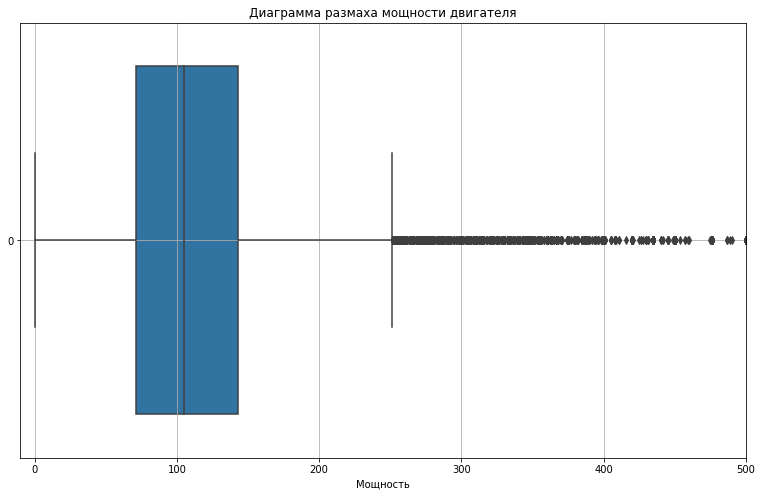

In [60]:
plt.figure(figsize=(13, 8))

sns.boxplot(data = data['Power'], orient='h')

plt.xlim(-10, 500)

plt.title('Диаграмма размаха мощности двигателя')
plt.xlabel('Мощность')
plt.grid(True)

plt.show()

В столбце Power установим ограничение до 250 л.с. 

In [61]:

data['Power'] = data['Power'].replace(0, np.NaN) \
.fillna(data.groupby('Brand')['Power'].transform(lambda x: x.median() if x.median() else np.nan))


**Вывод по разделу работы с данными:**
<br> 
1. В данных мы обнаружили признаки, которые не влияют на целевой признак - цену (Price). Это столбцы: DateCrawled, Model, RegistrationMonth, DateCreated, NumberOfPictures, LastSeen. Удалили их, так как они не нужны нам для исследования. 
2. Важные признаки, необходимые для исследования: VehicleType, RegistrationYear, Gearbox, Power, Kilometer, FuelType, Brand, Repaired, PostalCode.
3. В признаках, которые влияют на цену, обнаружены и пропуски, и нулевые значения, и дубликаты и другие аномалии.
4. Проведена обработка аномалий, отработаны пропущенные значения.

## Обучение моделей

Заменим категориальные признаки числовыми

In [62]:

data_copy = data.copy()

# разделим данные на признаки и целевой признак
target = data_copy[['Price']]
features = data_copy.drop(['Price'], axis=1)

# разделим данные на обучающую, валидационную и тестовую выборки
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

# задаём категориальные признаки
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']


encoder = OrdinalEncoder(dtype=np.int16)
encoder.fit(features_train[cat_features])

# применим кодировщик к выборкам
features_train[cat_features] = encoder.transform(features_train[cat_features])
features_valid[cat_features] = encoder.transform(features_valid[cat_features])
features_test[cat_features] = encoder.transform(features_test[cat_features])

features_train = features_train.fillna(0)
features_valid = features_valid.fillna(0)

features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape


((197684, 8), (197684, 1), (65895, 8), (65895, 1), (65895, 8), (65895, 1))

**Градиентный бустинг CatBoost**<br>
Подберём оптимальные значения RMSE и глубины

0:	learn: 3650.9311113	total: 71.2ms	remaining: 2.06s
5:	learn: 2858.4349095	total: 142ms	remaining: 568ms
10:	learn: 2666.6279351	total: 220ms	remaining: 380ms
15:	learn: 2553.8362636	total: 297ms	remaining: 260ms
20:	learn: 2473.0541908	total: 378ms	remaining: 162ms
25:	learn: 2419.9361193	total: 449ms	remaining: 69.2ms
29:	learn: 2388.5520427	total: 508ms	remaining: 0us
0:	learn: 2738.8533169	total: 26.7ms	remaining: 775ms
5:	learn: 2124.0026664	total: 151ms	remaining: 602ms
10:	learn: 1984.5528795	total: 271ms	remaining: 467ms
15:	learn: 1921.1561523	total: 391ms	remaining: 342ms
20:	learn: 1879.2498293	total: 519ms	remaining: 222ms
25:	learn: 1845.7408475	total: 650ms	remaining: 99.9ms
29:	learn: 1824.2662424	total: 751ms	remaining: 0us
0:	learn: 2411.3601633	total: 65.5ms	remaining: 1.9s
5:	learn: 1880.2087212	total: 342ms	remaining: 1.37s
10:	learn: 1776.2801931	total: 621ms	remaining: 1.07s
15:	learn: 1719.2834253	total: 907ms	remaining: 794ms
20:	learn: 1678.7276011	total: 1.1

'Лучшее значение RMSE = 1758.013935378361, лучшая глубина дерева = 16'

'Время обучения CatBoostRegressor: 22.9108 секунд'

'Время предсказания CatBoostRegressor: 0.0168 секунд'

CPU times: user 16.9 s, sys: 7.96 s, total: 24.8 s
Wall time: 29.1 s


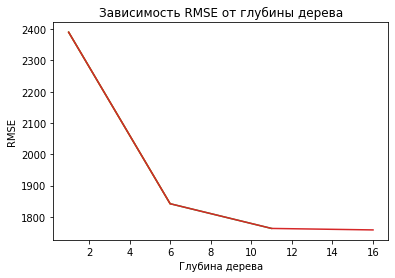

In [63]:
%%time
best_result = 5000
best_train_time_cb = 0
best_predict_time_cb = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_cb = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=depth, random_state=12345, verbose=5)
    start_time = time.time()
    model_cb.fit(features_train, target_train)
    end_time = time.time()
    train_time_cb = end_time - start_time
    
    start_time = time.time()
    predictions_valid = model_cb.predict(features_valid)
    end_time = time.time()
    predict_time_cb = end_time - start_time
    
    result = mean_squared_error(target_valid, predictions_valid, squared=False)
    depths.append(depth)
    results.append(result)

    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth_cb = depth
        best_result_cb = result
        best_train_time_cb = train_time_cb
        best_predict_time_cb = predict_time_cb

display(f"Лучшее значение RMSE = {best_result_cb}, лучшая глубина дерева = {best_depth_cb}")
display(f"Время обучения CatBoostRegressor: {best_train_time_cb:.4f} секунд")
display(f"Время предсказания CatBoostRegressor: {best_predict_time_cb:.4f} секунд")

**Модель дерева решений**<br>
Выберем дерево с минимальным показателем RMSE.

'Лучшее значение RMSE = 1933.2179562914057, лучшая глубина дерева = 16'

'Время обучения DecisionTreeRegressor: 0.4126 секунд'

'Время предсказания DecisionTreeRegressor: 0.0156 секунд'

CPU times: user 1.08 s, sys: 1.09 ms, total: 1.08 s
Wall time: 1.09 s


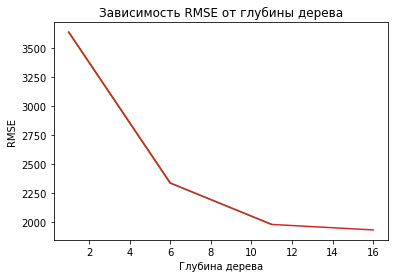

In [64]:
%%time
best_result = 5000
depths = []
results = []
best_train_time_dtr = 0
best_predict_time_dtr = 0

for depth in range(1, 21, 5):
    model_dtr = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    start_time = time.time()
    model_dtr.fit(features_train, target_train)
    end_time = time.time()
    train_time_dtr = end_time - start_time
    start_time = time.time()
    predictions_valid = model_dtr.predict(features_valid)
    end_time = time.time()
    predict_time_dtr = end_time - start_time
    
    result = mean_squared_error(target_valid, predictions_valid, squared=False)
    results.append(result)
    depths.append(depth)
    
    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth_dtr = depth
        best_result_dtr = result
        best_train_time_dtr = train_time_dtr
        best_predict_time_dtr = predict_time_dtr

display(f"Лучшее значение RMSE = {best_result_dtr}, лучшая глубина дерева = {best_depth_dtr}")
display(f"Время обучения DecisionTreeRegressor: {best_train_time_dtr:.4f} секунд")
display(f"Время предсказания DecisionTreeRegressor: {best_predict_time_dtr:.4f} секунд")


**Градиентный бустинг LightGBM**<br>
Установим параметры и найдём лучшую глубину

In [65]:

params = {
    "iterations": 20,
    "learning_rate": 1,
    "max_depth_lgbm": 10,
    "loss_function": "RMSE",
    "random_state": 12345,
    "bootstrap_type": 'gbdt',
}

lgbm_model = lightgbm.LGBMRegressor(**params)

start_time = time.time()
lgbm_model.fit(features_train, target_train, categorical_feature=cat_features)
end_time = time.time()
train_time_lgbm = end_time - start_time

start_time = time.time()
predictions_valid = lgbm_model.predict(features_valid)
end_time = time.time()
predict_time_lgbm = end_time - start_time

best_result_lgbm = mean_squared_error(target_valid, predictions_valid, squared=False)

display(f"Лучшее значение RMSE = {best_result_lgbm}, лучшая глубина дерева = {params['max_depth_lgbm']}")
display(f"Время обучения LightGBM: {train_time_lgbm:.4f} секунд")
display(f"Время предсказания LightGBM: {predict_time_lgbm:.4f} секунд")



[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: max_depth_lgbm
[LightGBM] [Warning] Unknown parameter: bootstrap_type
[LightGBM] [Warning] Unknown parameter: loss_function


'Лучшее значение RMSE = 1781.3825668259149, лучшая глубина дерева = 10'

'Время обучения LightGBM: 35.5606 секунд'

'Время предсказания LightGBM: 0.4308 секунд'

Обучим модель с лучшими параметрами

**Вывод по разделу обучения моделей:**<br>
Градиентный бустинг CatBoost показал результаты:  RMSE - 1758, глубина - 16, время обучения - 22.91 с, время предсказания - 0.02 с.<br>
Модель дерева решений показала результаты: RMSE - 1933, глубина - 16, время обучения -  0.41 с, время предсказания - 0.02 с.<br>
Градиентный бустинг LightGBM показал результаты: RMSE - 1781, глубина - 10, время обучения - 35.5 с, время предсказания - 0.43 с.<br><br>
Лучшую скорость обучения показала модель Дерева решений. <br><br>
Все модели удовлетворяют условию RMSE < 2500.


## Анализ моделей

In [68]:
# результаты для CatBoostRegressor
catboost_results = pd.DataFrame({
    'Модель': ['CatBoostRegressor'],
    'Глубина дерева': [best_depth_cb],
    'RMSE': [best_result_cb],
    'Время обучения (сек)': [best_train_time_cb],
    'Время предсказания (сек)': [best_predict_time_cb]
})

# результаты для DecisionTreeRegressor
dtr_results = pd.DataFrame({
    'Модель': ['DecisionTreeRegressor'],
    'Глубина дерева': [best_depth_dtr],
    'RMSE': [best_result_dtr],
    'Время обучения (сек)': [best_train_time_dtr],
    'Время предсказания (сек)': [best_predict_time_dtr]
})

# результаты для LightGBM
lgbm_results = pd.DataFrame({
    'Модель': ['LightGBM'],
    'Глубина дерева': [10],
    'RMSE': [best_result_lgbm],
    'Время обучения (сек)': [train_time_lgbm],
    'Время предсказания (сек)': [predict_time_lgbm]
})

# объединим результаты в один DataFrame
results_df = pd.concat([catboost_results, dtr_results, lgbm_results], ignore_index=True)

# выведем таблицу
display(results_df)

,Модель,Глубина дерева,RMSE,Время обучения (сек),Время предсказания (сек)
0,CatBoostRegressor,16,1758.013935,22.910797,0.016834
1,DecisionTreeRegressor,16,1933.217956,0.412567,0.015626
2,LightGBM,10,1781.382567,35.560573,0.430802


**Вывод по разделу анализа моделей:** <br><br>
По показателям RMSE лучшего всего показала себя модель градиентного бустинга CatBoost:
<br><br>
CatBoost = 1721 <br>
DecisionTreeRegressor = 1950 <br>
LightGBM  = 1748<br>

Проверим модель CatBoost, показавшую лучшие результаты на тестовой выборке

In [ ]:
predictions_test = model_cb.predict(features_test)
test_result = mean_squared_error(target_test, predictions_test, squared=False)

print(f"Лучшее значение RMSE: {best_result_cb}, Best max_depth: {best_depth_cb}")
print(f"RMSE на тестовой выбороке: {test_result}")

Предсказания удовлетворяет заданному условию.

**ВЫВОД**
<br><br>
В процессе предобработки и анализа данных:
- удалили ненужные признаки, 
- категориальные признаки преобразовали в количественные, 
- обработали пропуски в признаках, 
- удалили аномальные значения признаков.
<br><br>
В разделе обучения моделей:
- подготовили выборки для обучения моделей при помощи train_test_split,
- обучили три модели с подбором оптимальных параметров:<br>
CatBoost - получили оптимальную глубину 16 за 46.8 с<br>
DecisionTreeRegressor - получили оптимальную глубину 16 за 0.55 с<br>
LightGBM - получили оптимальную глубину 10 за 190 с<br>
<br>
В процессе анализа моделей при получения предсказаний модели показали результаты:<br><br>
CatBoost = 1721 <br>
DecisionTreeRegressor = 1950 <br>
LightGBM  = 1748 <br>
<br>
Наилучшим образом показла себя модель CatBoost.